# Homework 3: Augmented Reality with Planar Homographies

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q2**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**: 

 - Kirpa Kaur: in exercise 3

---

# Q1 Preliminaries

## Q1.1 The Direct Linear Transform


### Q1.1.1 (3 points)

How many degrees of freedom does **h** have?

---

8

This is because the homography matrix $H$ is a $3 \times 3$ matrix with 9 elements, but it is defined up to a scale factor in homogeneous coordinates, reducing the degrees of freedom to 8.

---

### Q1.1.2 (2 points)

How many point pairs are required to solve **h**?

---

4

Each point correspondence provides 2 constraints (x and y coordinates in homogeneous form), and with 8 degrees of freedom for $\mathbf{h}$, at least 4 pairs are needed to form a sufficient system of equations.

---

### Q1.1.3 (5 points)

Derive $\textbf{A}_i$

---

For each point pair $(x_1, y_1)$ and $(x_2, y_2)$ in homogeneous coordinates, $\mathbf{A}_i$ is a $2 \times 9$ matrix derived from the homography equation $\mathbf{x}_1^i = H \mathbf{x}_2^i$. It is given by:

$$\mathbf{A}_i = \begin{bmatrix}
-x_2 & -y_2 & -1 & 0 & 0 & 0 & x_1 x_2 & y_1 x_2 & x_1 \\
0 & 0 & 0 & -x_2 & -y_2 & -1 & x_1 y_2 & y_1 y_2 & y_1
\end{bmatrix}$$

This matrix represents the two linear equations for each point pair, forming the system $A \mathbf{h} = 0$ to solve for $\mathbf{h}$.

---

### Q1.1.4 (5 points)

What will be the trivial solution for **h**? Is the matrix **A** full rank? Why/Why not? What impact will it have on the singular values (i.e. eigenvalues of $\textbf{A}^T\textbf{A}$)?

---


1. **Trivial solution**: 

The trivial solution for $\mathbf{h}$ is $\mathbf{h} = 0$, as it satisfies $A \mathbf{h} = 0$ but does not provide a meaningful homography.

2. **Is $\mathbf{A}$ full rank? Why/Why not?**: 

No, $\mathbf{A}$ is not full rank. With $N$ point pairs, $\mathbf{A}$ has $2N$ rows and 9 columns. The rank of $\mathbf{A}$ is at most 8 because $\mathbf{h}$ has only 8 degrees of freedom due to the scale ambiguity in homogeneous coordinates. If $\mathbf{A}$ were full rank (rank 9), the null space would be trivial ($\mathbf{h} = 0$), preventing a non-trivial solution for $\mathbf{h}$.

3. **Impact on singular values**: 

Since $\mathbf{A}$ has rank 8 (not 9), one of its singular values is zero. This corresponds to the eigenvalue of $\mathbf{A}^T \mathbf{A}$ being zero, reflecting the one-dimensional null space that allows for a non-trivial $\mathbf{h}$.

---

## Q1.2 Homography Theory Questions

### Q1.2.1 (5 points)

Prove that there exists a homography **H** that satisfies $\textbf{x}_1 ≡ \textbf{Hx}_2$, given two cameras separated by a pure rotation.

---

By definition we have that 

$$x_1 = K_1[I \ 0]X$$
$$x_2 = K_2[R \ 0]X$$

then 

$$(R^{-1}K_2^{-1})x_2 = R^{-1}K_2^{-1}(K_2[R \ 0]X) = R^{-1}[R \ 0]X = [I \ 0]X$$

thus,

$$x_1 = K_1[I \ 0]X = K_1(R^{-1}K_2^{-1}x_2) = (K_1R^{-1}K_2^{-1})x_2$$

if we define 

$$H := K_1R^{-1}K_2^{-1}$$

we got our desire homography, $H$ such as:

$$x_1 = Hx_2$$

---

### Q1.2.2 (5 points):

Show that $\textbf{H}^2$ is the homography corresponding to a rotation of $2\theta$.

---

If $\textbf{H}$ is the homography corresponding to a rotation of $\theta$, then for any $x$

$$y := \textbf{H}x$$

is the rotation of $\theta$ of x, and 

$$z := \textbf{H}y$$

is the rotation of $\theta$ of y, or in other words, the rotation of $\theta$ of the rotation of $\theta$ of x, which is the rotation of $2\theta$ of x. Then 

$$z = \textbf{H}y = \textbf{H}(\textbf{H}x) = \textbf{H}^2x$$

is the rotation of $2\theta$ for any $x$.

---

# Initialization

Run the following code to import the modules you'll need.

In [ ]:
import os
import numpy as np
import cv2
import skimage.color
import pickle
from matplotlib import pyplot as plt
import scipy
from skimage.util import montage
import time

PATCHWIDTH = 9

def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def write_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

def briefMatch(desc1,desc2,ratio):

    matches = skimage.feature.match_descriptors(desc1,desc2,
                                                'hamming',
                                                cross_check=True,
                                                max_ratio=ratio)
    return matches

def plotMatches(img1,img2,matches,locs1,locs2):

    fig, ax = plt.subplots(nrows=1, ncols=1)
    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    skimage.feature.plot_matched_features(img1,img2,
                                          keypoints0=locs1,keypoints1=locs2,
                                          matches=matches,ax=ax,
                                          matches_color='r',only_matches=True)
    plt.show()
    return

def makeTestPattern(patchWidth, nbits):

    np.random.seed(0)
    compareX = patchWidth*patchWidth * np.random.random((nbits,1))
    compareX = np.floor(compareX).astype(int)
    np.random.seed(1)
    compareY = patchWidth*patchWidth * np.random.random((nbits,1))
    compareY = np.floor(compareY).astype(int)

    return (compareX, compareY)

def computePixel(img, idx1, idx2, width, center):

    halfWidth = width // 2
    col1 = idx1 % width - halfWidth
    row1 = idx1 // width - halfWidth
    col2 = idx2 % width - halfWidth
    row2 = idx2 // width - halfWidth
    return 1 if img[int(center[0].item()+row1), int(center[1].item()+col1)] < img[int(center[0].item()+row2), int(center[1].item()+col2)] else 0

def computeBrief(img, locs):

    patchWidth = 9
    nbits = 256
    compareX, compareY = makeTestPattern(patchWidth,nbits)
    m, n = img.shape

    halfWidth = patchWidth//2

    locs = np.array(list(filter(lambda x: halfWidth <= x[0] < m-halfWidth and halfWidth <= x[1] < n-halfWidth, locs)))
    desc = np.array([list(map(lambda x: computePixel(img, x[0], x[1], patchWidth, c), zip(compareX, compareY))) for c in locs])

    return desc, locs

def corner_detection(img, sigma):

    # fast method
    result_img = skimage.feature.corner_fast(img, n=PATCHWIDTH, threshold=sigma)
    locs = skimage.feature.corner_peaks(result_img, min_distance=1)
    return locs

def loadVid(path):

    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name

    cap = cv2.VideoCapture(path)

    # get fps, width, and height
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Append frames to list
    frames = []

    # Check if camera opened successfully
    if cap.isOpened()== False:
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):

        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            #Store the resulting frame
            frames.append(frame)
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    frames = np.stack(frames)

    return frames, fps, width, height

# Download data

Download the required data and setup the results directory. If running on colab, DATA_PARENT_DIR must be <br> DATA_PARENT_DIR = '/content/' <br> <br> Otherwise, use the local directory of your choosing. Data will be downloaded to DATA_PARENT_DIR/hw3_data and a subdirectory DATA_PARENT_DIR/results will be created.

In [2]:
# Only change this if you are running locally
# Default on colab: DATA_PARENT_DIR = '/content/'

# Data will be downloaded to DATA_PARENT_DIR/hw3_data
# A subdirectory DATA_PARENT_DIR/results will be created

DATA_PARENT_DIR = 'content/'

if not os.path.exists(DATA_PARENT_DIR):
  raise RuntimeError('DATA_PARENT_DIR does not exist: ', DATA_PARENT_DIR)

RES_DIR = os.path.join(DATA_PARENT_DIR, 'results')
if not os.path.exists(RES_DIR):
  os.mkdir(RES_DIR)
  print('made directory: ', RES_DIR)


#paths different files are saved to
# OPTIONAL:
# feel free to change if funning locally
ROT_MATCHES_PATH = os.path.join(RES_DIR, 'brief_rot_test.pkl')
ROT_INV_MATCHES_PATH = os.path.join(RES_DIR, 'ec_brief_rot_inv_test.pkl')
AR_VID_FRAMES_PATH = os.path.join(RES_DIR, 'q_3_1_frames.npy')
AR_VID_FRAMES_EC_PATH = os.path.join(RES_DIR, 'q_3_2_frames.npy')

HW3_SUBDIR = 'hw3_data'
DATA_DIR = os.path.join(DATA_PARENT_DIR, HW3_SUBDIR)
ZIP_PATH = DATA_DIR + '.zip'
# if not os.path.exists(DATA_DIR):
#   !wget 'https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip' -O $ZIP_PATH
#   !unzip -qq $ZIP_PATH -d $DATA_PARENT_DIR

# Q2 Computing Planar Homographies

## Q2.1 Feature Detection and Matching

### Q2.1.1 (5 points):

How is the FAST detector different from the Harris corner detector that you've seen in the lectures? Can you comment on its computation performance compared to the Harris corner detector?

---

The FAST (Features from Accelerated Segment Test) detector differs from the Harris Corner Detector in that it uses a more efficient pixel intensity comparison approach rather than computing gradients and response matrices. FAST determines a corner by checking if a set of contiguous pixels around a candidate pixel are significantly brighter or darker than the center pixel, whereas Harris relies on eigenvalue analysis of the local gradient matrix.

In terms of computational performance, FAST is significantly faster than Harris because it avoids expensive matrix operations, making it well-suited for real-time applications. However, FAST does not inherently provide corner strength scores, making it less robust in some cases.

---

### Q2.1.2 (5 points):

How is the BRIEF descriptor different from the filterbanks you've seen in the lectures? Could you use any one of the those filter banks as a descriptor?

---

The BRIEF (Binary Robust Independent Elementary Features) descriptor differs from filter banks because it is a binary descriptor that encodes local image patches using simple intensity comparisons, rather than using convolution-based feature extraction like filter banks. Filter banks, such as Gabor or wavelet filters, analyze frequency and orientation information, while BRIEF focuses on computational efficiency with binary comparisons.

Using a filter bank as a descriptor is possible but may not be as efficient as BRIEF. Filter banks typically require more storage and computational resources, whereas BRIEF produces compact binary descriptors that are easier to compare and store.

---

### Q2.1.3 (5 points):

Describe how the Hamming distance and Nearest Neighbor can be used to match interest points with BRIEF descriptors. What benefits does the Hamming distance have over a more conventional Euclidean distance measure in our setting?

---

The Hamming distance is used to compare binary descriptors, such as BRIEF, by counting the number of bit differences between two descriptors. The Nearest Neighbor approach helps match interest points by finding the descriptor with the smallest Hamming distance.

Compared to Euclidean distance (which is used for floating-point descriptors like SIFT), Hamming distance is much faster to compute, as it only involves bitwise XOR operations and bit counting. This makes it highly efficient, especially in large-scale matching tasks.

---

### Q2.1.4 (10 points):

#### Implement the function matchPics()

In [ ]:
def matchPics(I1, I2, ratio, sigma):
    """

    Match features across images

    Input
    -----
    I1, I2: Source images (RGB or Grayscale uint8)
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector

    Returns
    -------
    matches: List of indices of matched features across I1, I2 [p x 2]
    locs1, locs2: Pixel coordinates of matches [N x 2]
    """

    # ===== your code here! =====

    # TODO: Convert images to GrayScale
    # Input images can be either RGB or Grayscale uint8 (0 -> 255). Both need
    # to be supported.
    # Input images must be converted to normalized Grayscale (0.0 -> 1.0)
    # skimage.color.rgb2gray may be useful if the input is RGB.

    # Convert images to grayscale if needed
    if len(I1.shape) == 3:
        I1 = skimage.color.rgb2gray(I1)
    if len(I2.shape) == 3:
        I2 = skimage.color.rgb2gray(I2)

    # TODO: Detect features in both images

    locs1 = corner_detection(I1, sigma)
    locs2 = corner_detection(I2, sigma)

    # TODO: Obtain descriptors for the computed feature locations
    
    desc1, locs1 = computeBrief(I1, locs1)
    desc2, locs2 = computeBrief(I2, locs2)

    # TODO: Match features using the descriptors
    
    matches = briefMatch(desc1, desc2, ratio)

    # ==== end of code ====

    return matches, locs1, locs2

#### Implement the function displayMatched

In [4]:
def displayMatched(I1, I2, ratio, sigma):
    """
    Displays matches between two images

    Input
    -----
    I1, I2: Source images
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    """

    print('Displaying matches for ratio: ', ratio, ' and sigma: ', sigma)

    # ===== your code here! =====
    # TODO: Use matchPics and plotMatches to visualize your results
    
    matches, locs1, locs2 = matchPics(I1, I2, ratio, sigma)
    plotMatches(I1,I2,matches,locs1,locs2)

    # ==== end of code ====


#### Visualize the matches

Use the cell below to visualize the matches. The resulting figure should look similar (but not necessarily identical) to Figure 2.

Feel free to play around with the images and parameters. Please use the original images when submitting the report.

Figure 2 parameters:

*   image1_name = "cv_cover.jpg"
*   image1_name = "cv_desk.png"
*   ratio = 0.7
*   sigma = 0.15

Displaying matches for ratio:  0.7  and sigma:  0.15


C:\Users\javie\AppData\Local\Temp\ipykernel_19760\1312391709.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


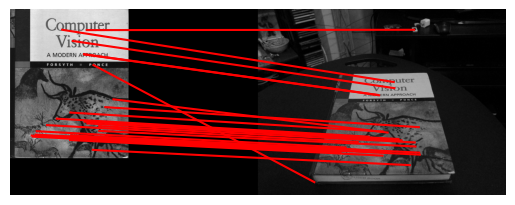

In [34]:
# Feel free to play around with these parameters
# BUT when submitting the report use the original images
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"
ratio = 0.7
sigma = 0.15

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

displayMatched(image1, image2, ratio, sigma)

### Q2.1.5 (10 points):

Experiment with different sigma and ratio values. Conduct a small ablation study, and include the figures displaying the matched features with various parameters in your write-up. Explain the effect of these two paremeters respectively.

---

Explain the effect of these two parameters:

**Effect of Ratio**

 - Lower ratio (0.6): More strict filtering, leading to fewer matches but higher quality.
 - Higher ratio (0.8): More lenient, allowing more matches, but some may be incorrect.
 - Observation: Increasing the ratio results in more matches but also introduces more false positives (incorrect matches).

**Effect of Sigma**

 - Lower sigma (0.05): Removes more matches, leading to fewer but higher-confidence correspondences.
 - Higher sigma (0.1): Allows more matches, possibly including noise.
 - Observation: Higher sigma values increase the number of matches but can introduce more errors.

**Conclusion**

The best parameter choice depends on the application:

 - If precision is more important, a lower ratio (0.6-0.7) and lower sigma (0.05-0.1) should be used.
 - If more matches are needed and some noise is acceptable, higher ratio (0.8) and higher sigma (0.1) can be considered.
 
---

Displaying matches for ratio:  0.6  and sigma:  0.05


C:\Users\javie\AppData\Local\Temp\ipykernel_19760\3357110167.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0].item()+row1), int(center[1].item()+col1)] < img[int(center[0].item()+row2), int(center[1].item()+col2)] else 0


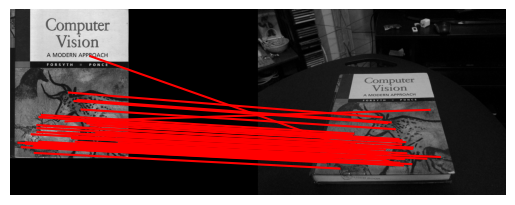

Displaying matches for ratio:  0.8  and sigma:  0.05


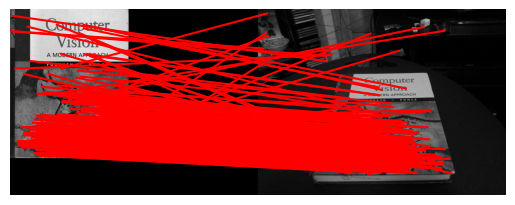

Displaying matches for ratio:  0.6  and sigma:  0.1


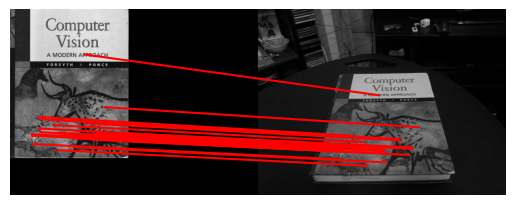

Displaying matches for ratio:  0.8  and sigma:  0.1


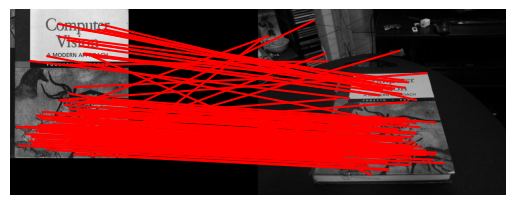

In [150]:
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# ===== your code here! =====
# Experiment with different sigma and ratio values.
# Use displayMatches to visualize.
# Include the matched feature figures in the write-up.

for sigma in [0.05, 0.1]:
  for ratio in [0.6, 0.8]:
    displayMatched(image1, image2, ratio, sigma)

# ==== end of code ====

### Q2.1.6 (10 points):

#### Implement the function briefRot

In [5]:
def briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Tests Brief with rotations.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    # Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    degrees = list(range(min_deg, max_deg, deg_inc))
    n = len(degrees)
    nrot=1

    for i in degrees:
        print(i)

        # ===== your code here! =====
        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)
        image_rot = scipy.ndimage.rotate(image, i, reshape=False)
        image_rot_reshape = scipy.ndimage.rotate(image, i, reshape=True)

        # TODO: Match features in images
        matches, locs1, locs2 = matchPics(image, image_rot, ratio, sigma)

        if len(matches) == 0:
          print(f"Skipping plot for rotation {i} due to no valid matches.")
          continue

        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)
        if nrot == 1 and i > 100:
          nrot += 1
          print("No reshape")
          plotMatches(image, image_rot, matches, locs1, locs2)
          print("With reshape")
          displayMatched(image, image_rot_reshape, ratio, sigma)
        elif nrot == 2 and i > 200:
          nrot += 1
          print("No reshape")
          plotMatches(image, image_rot, matches, locs1, locs2)
          print("With reshape")
          displayMatched(image, image_rot_reshape, ratio, sigma)
        elif nrot == 3 and i > 300:
          nrot += 1
          print("No reshape")
          plotMatches(image, image_rot, matches, locs1, locs2)
          print("With reshape")
          displayMatched(image, image_rot_reshape, ratio, sigma)

        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(i)
        match_counts.append(len(matches))

        # ==== end of code ====

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_MATCHES_PATH, matches_to_save)

def dispBriefRotHist(matches_path=ROT_MATCHES_PATH):
    # Check if pickle file exists
    if not os.path.exists(matches_path):
      raise RuntimeError('matches_path does not exist. did you call briefRot?')

    # Read from pickle file
    match_counts, match_degrees, deg_inc = read_pickle(matches_path)

    # Display histogram
    # Bins are centered and separated every 10 degrees
    plt.figure()
    bins = [x - deg_inc/2 for x in match_degrees]
    bins.append(bins[-1] + deg_inc)
    plt.hist(match_degrees, bins=bins, weights=match_counts, log=True)
    #plt.hist(match_degrees, bins=[10 * (x-0.5) for x in range(37)], weights=match_counts, log=True)
    plt.title("Histogram of BREIF matches")
    plt.ylabel("# of matches")
    plt.xlabel("Rotation (deg)")
    plt.tight_layout()

    output_path = os.path.join(RES_DIR, 'histogram.png')
    plt.savefig(output_path)

#### Visualize the matches under rotation

See debugging tips in handout.


0


C:\Users\javie\AppData\Local\Temp\ipykernel_19760\3357110167.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0].item()+row1), int(center[1].item()+col1)] < img[int(center[0].item()+row2), int(center[1].item()+col2)] else 0


20
40
60
80
100
120
No reshape


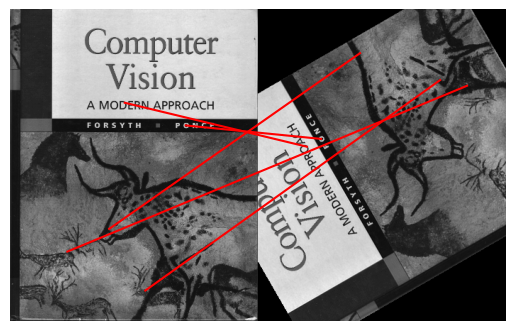

With reshape
Displaying matches for ratio:  0.7  and sigma:  0.15


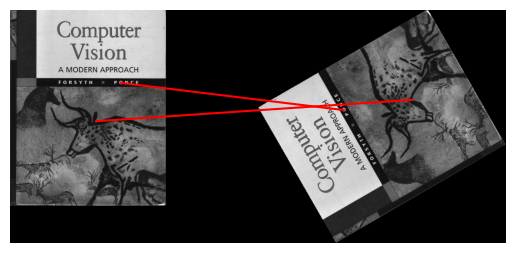

140
160
180
200
220
No reshape


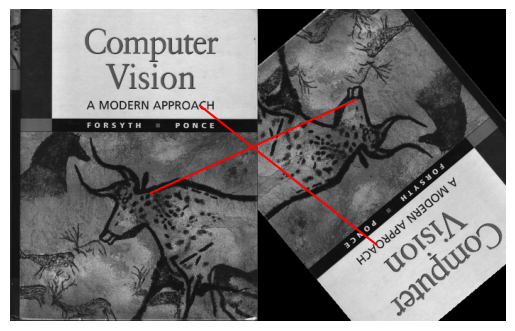

With reshape
Displaying matches for ratio:  0.7  and sigma:  0.15


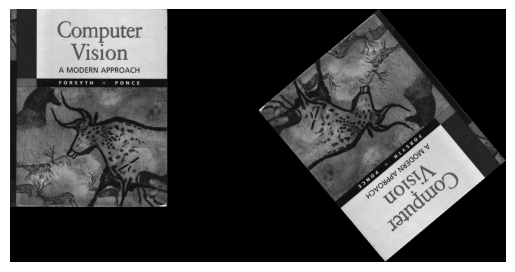

240
260
280
300
320
No reshape


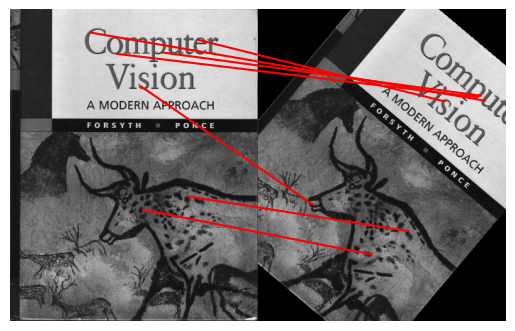

With reshape
Displaying matches for ratio:  0.7  and sigma:  0.15


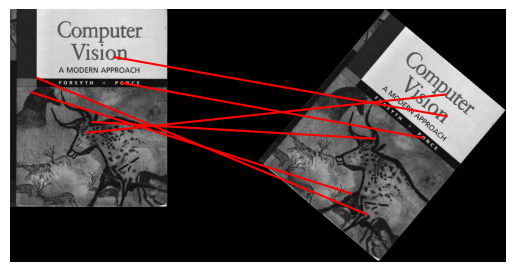

340


In [148]:
# defaults are:
# min_deg = 0
# max_deg = 360
# deg_inc = 10
# ratio = 0.7
# sigma = 0.15
# filename = 'cv_cover.jpg'

# Controls the rotation degrees
min_deg = 0
max_deg = 360
deg_inc = 20

# Brief feature descriptor and Fast feature detector paremeters
# (change these if you want to use different values)
ratio = 0.7
sigma = 0.15

# image to rotate and match
# (no need to change this but can if you want to experiment)
filename = 'cv_cover.jpg'

# Call briefRot
briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename)

#### Plot the histogram

See debugging tips in handout.

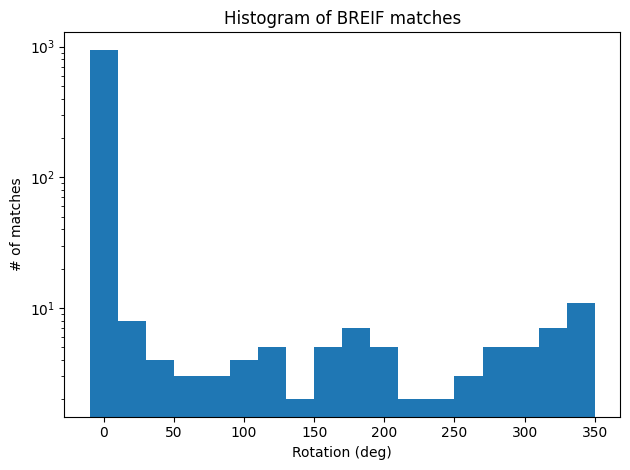

In [149]:
dispBriefRotHist()

---

Explain why you think the BRIEF descriptor behaves this way: 

It finds a lot of matches for a 0 degree rotation as spected (is the same image) but then starts lossing the track of the matches. One of the reasons for this comes because of the different images sizes of both images while generating the rotation. The patches will be different and this creates confusion on the BRIEF descriptor.

---

### Q2.1.7.1 (Extra Credit - 5 points):

Design a fix to make BRIEF more rotation invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.

In [ ]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)

# TODO: Feel free to modify the inputs and the function body as necessary
# This is only an outline
def briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Rotation invariant Brief.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    nrot = 1

    for k in range(min_deg, max_deg, deg_inc):
        print(k)

        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)
        image_rot = scipy.ndimage.rotate(image, k, reshape=False)
        image_rot_reshape = scipy.ndimage.rotate(image, k, reshape=True)

        # TODO: Brief matcher that is rotation invariant
        # Feel free to define additional helper functions as necessary

        # # first get some matches
        # matches, locs1, locs2 = matchPics(image, image_rot, ratio, sigma)

        # points_image     = locs1[matches[:, 0]]
        # points_image_rot = locs2[matches[:, 1]]

        # # then get the 
        # #  - (average) ratio 
        # #  - (average) angle 
        # # between the points of the original image and the other -> this will work supposing we get already good matchings...
        # dist_coef = []
        # vect_angle = []
        # for i in range(len(points_image)):
        #   for j in range(i+1, len(points_image)):
        #     xn = np.linalg.norm(points_image[i] - points_image[j])
        #     rn = np.linalg.norm(points_image_rot[i] - points_image_rot[j])
        #     dist_coef.append(xn / rn)
        #     dot = np.dot((points_image[i] - points_image[j]), (points_image_rot[i] - points_image_rot[j]))
        #     angle = np.arccos(dot / (xn * rn))
        #     vect_angle.append(angle)
        # coef  = 1. / np.mean(dist_coef)
        # angle = (-360*np.mean(np.abs(vect_angle)) / (2*np.pi)) % 360 
        
        # # then transform the new image with this ratio so at least the matches are the same size (still different orientation)
        # image_rot = cv2.resize(image_rot, None, fx=coef, fy=coef, interpolation=cv2.INTER_AREA)
        # image_rot = scipy.ndimage.rotate(image_rot, angle, reshape=True)
        # matches, locs1, locs2 = matchPics(image, image_rot, ratio, sigma)

        if len(matches) == 0:
          print(f"Skipping plot for rotation {i} due to no valid matches.")
          continue

        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        plotMatches(image, image_rot, matches, locs1, locs2)

        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(k)
        match_counts.append(len(matches))

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_INV_MATCHES_PATH, matches_to_save)

# ==== end of code ====


#### Visualize your implemented function


In [ ]:
min_deg = 80
max_deg = 360
deg_inc = 80
filename = 'cv_cover.jpg'

# ===== your code here! =====
# TODO: Call briefRotInvEc and visualize

ratio = 0.7
sigma = 0.15

briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename)

# ==== end of code ====


#### Plot Histogram

In [ ]:
dispBriefRotHist(matches_path=ROT_INV_MATCHES_PATH)

---

Compare the histograms with an without rotation invariance. Explain your rotation invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---

### Q2.1.7.2 (Extra Credit - 5 points):

Design a fix to make BRIEF more scale invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.


In [ ]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)

# TODO: Modify the inputs and the function body as necessary
def briefScaleInvEc(ratio, sigma, filename):

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_scales = [] # stores the scaling factors
    match_counts = [] # stores the number of matches at each scaling factor

    for i in [1]:
        # Scale Image
        image_scale = cv2.resize(image,(int(image.shape[1]/(2**i)),
                                        int(image.shape[0]/(2**i))),
                                 interpolation = cv2.INTER_AREA)

        # TODO: Brief matcher that is scale invariant
        # Feel free to define additional helper functions as necessary

        # Compare to regular matchPics
        matches_orig, locs1_orig, locs2_orig = matchPics(image,
                                                         image_scale,
                                                         ratio, sigma)

        print('plotting non-scale invariant scale: ', 2**i)
        plotMatches(image, image_scale, matches_orig, locs1_orig,
                    locs2_orig)
        print('plotting scale-invariant: ', 2**i)
        plotMatches(image, image_scale, matches, locs1, locs2)

# ==== end of code ====

#### Visualize your implemented function

In [ ]:
# ===== your code here! =====
# TODO: Call briefScaleInvEc and visualize
# You may change any parameters and the function body as necessary

filename = 'cv_cover.jpg'

ratio = 0.7
sigma = 0.15

briefScaleInvEc(ratio, sigma, filename)
# ==== end of code ====

---

Explain your scale invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---


## Q2.2 Homography Computation

### Q2.2.1 (15 Points):

Implement the function computeH

In [7]:
def computeH(x1, x2):
    """
    Compute the homography between two sets of points

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    if x1.shape != x2.shape:
        raise RuntimeError('number of points do not match')

    # ===== your code here! =====
    # TODO: Compute the homography between two sets of points

    N = x1.shape[0]
    if N < 4:
        raise RuntimeError("At least 4 point correspondences are required")
    
    # Construct the matrix A for Ah = 0
    A = []
    for i in range(N):
        x, y = x2[i, 0], x2[i, 1]  # Points in x2
        u, v = x1[i, 0], x1[i, 1]  # Corresponding points in x1

        A.append([-x, -y, -1,  0,  0,  0,  x*u, y*u, u])
        A.append([ 0,  0,  0, -x, -y, -1,  x*v, y*v, v])
    
    A = np.array(A)  # Convert list to numpy array

    # Solve for h using SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]  # The solution is the last row of V^T

    # Reshape into 3x3 homography matrix
    H2to1 = h.reshape(3, 3)
    H2to1 /= H2to1[2, 2]

    # ==== end of code ====
        
    return H2to1




### Q2.2.2 (10 points):

Implement the function computeH_norm

In [8]:
def computeH_norm(x1, x2):
    """
    Compute the homography between two sets of points using normalization

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """
    
    # Ensure both point sets have the same shape
    assert x1.shape == x2.shape, "Input point sets must have the same shape"
    
    N = x1.shape[0]
    if N < 4:
        raise RuntimeError("At least 4 points are required to compute a homography")
    
    # ===== TODO: Compute the centroid of the points =====
    centroid_x1 = np.mean(x1, axis=0)
    centroid_x2 = np.mean(x2, axis=0)

    # ===== TODO: Shift the origin of the points to the centroid =====
    x1_shifted = x1 - centroid_x1
    x2_shifted = x2 - centroid_x2

    # ===== TODO: Normalize the points so that the largest distance from the origin is sqrt(2) =====
    avg_dist_x1 = np.mean(np.sqrt(np.sum(x1_shifted**2, axis=1)))
    avg_dist_x2 = np.mean(np.sqrt(np.sum(x2_shifted**2, axis=1)))

    scale_x1 = np.sqrt(2) / avg_dist_x1
    scale_x2 = np.sqrt(2) / avg_dist_x2

    x1_normalized = x1_shifted * scale_x1
    x2_normalized = x2_shifted * scale_x2

    # ===== TODO: Similarity transform 1 =====
    T1 = np.array([
        [scale_x1, 0, -scale_x1 * centroid_x1[0]],
        [0, scale_x1, -scale_x1 * centroid_x1[1]],
        [0, 0, 1]
    ])

    # ===== TODO: Similarity transform 2 =====
    T2 = np.array([
        [scale_x2, 0, -scale_x2 * centroid_x2[0]],
        [0, scale_x2, -scale_x2 * centroid_x2[1]],
        [0, 0, 1]
    ])

    # Convert to homogeneous coordinates
    x1_hom = np.hstack([x1_normalized, np.ones((N, 1))])
    x2_hom = np.hstack([x2_normalized, np.ones((N, 1))])

    # ===== TODO: Compute homography =====
    H_normalized = computeH(x1_hom[:, :2], x2_hom[:, :2])  # Call the unnormalized homography function

    # ===== TODO: Denormalization =====
    H2to1 = np.linalg.inv(T1) @ H_normalized @ T2

    return H2to1


### Q2.2.3 (25 points):

Implement RANSAC

In [ ]:
def computeH_ransac(locs1, locs2, max_iters, inlier_tol):
    """
    Estimate the homography between two sets of points using ransac

    Input
    -----
    locs1, locs2: Lists of points
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    bestH2to1: 3x3 homography matrix that best transforms locs2 to locs1
    inliers: indices of RANSAC inliers

    """

    # ===== your code here! =====

    assert locs1.shape == locs2.shape, "Input point sets must have the same shape"
    
    N = locs1.shape[0]
    if N < 4:
        raise ValueError("At least 4 points are required for homography estimation")

    # TODO:
    # Compute the best fitting homography using RANSAC
    # given a list of matching points locs1 and loc2

    bestH2to1 = None
    best_inliers = np.zeros(N, dtype=bool)
    max_inliers_count = 0

    for _ in range(max_iters):

        # 1. Randomly sample 4 points
        idxs = np.random.choice(N, 4, replace=False)
        sample_locs1 = locs1[idxs]
        sample_locs2 = locs2[idxs]

        # 2. Compute homography using normalized DLT
        H = computeH_norm(sample_locs1, sample_locs2)

        # 3. Transform locs2 using H
        locs2_homogeneous = np.hstack([locs2, np.ones((N, 1))])  # Convert to homogeneous coordinates
        locs1_proj_homogeneous = (locs2_homogeneous @ H.T)  # Apply homography
        epsilon = 1e-8
        locs1_proj = (locs1_proj_homogeneous[:, :2] / 
                    (locs1_proj_homogeneous[:, 2:] + epsilon))  # Convert back to 2D

        # 4. Compute distances to true locs1
        distances = np.linalg.norm(locs1 - locs1_proj, axis=1)

        # 5. Count inliers
        inliers = distances < inlier_tol
        inliers_count = np.sum(inliers)

        # 6. Keep the best homography with the most inliers
        if inliers_count > max_inliers_count:
            bestH2to1 = H
            best_inliers = inliers
            max_inliers_count = inliers_count


    # ==== end of code ====

    return bestH2to1, best_inliers

### Q2.2.4 (10 points):

#### Implement the function compositeH

In [ ]:
def compositeH(H2to1, template, img):
    """
    Returns the composite image.

    Input
    -----
    H2to1: Homography from image to template
    template: template image to be warped
    img: background image

    Returns
    -------
    composite_img: Composite image

    """

    # ===== your code here! =====
    # TODO: Create a composite image after warping the template image on top
    # of the image using the homography 

    h_img, w_img = img.shape[:2]

    # Warp the template image using the given homography
    warped_template = cv2.warpPerspective(template, H2to1, (w_img, h_img))
    if len(warped_template.shape) == 2 or warped_template.shape[2] != img.shape[2]:
        warped_template = cv2.cvtColor(warped_template, cv2.COLOR_GRAY2BGR)

    # Create a 1-channel mask where the warped template is non-zero
    mask = (warped_template > 0).astype(np.uint8)  # Binary mask (1 where template is nonzero)
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    mask_inv = mask - 1

    # Extract the background part without the template area
    img_background = cv2.bitwise_and(img, img, mask=mask_inv)

    # Extract the template part that needs to be placed
    img_foreground = cv2.bitwise_and(warped_template, warped_template, mask=mask)

    # Combine the images to create the final composite
    composite_img = cv2.add(img_background, img_foreground)

    # ==== end of code ====

    return composite_img


#### Implement the function warpImage

In [ ]:
def warpImage(ratio, sigma, max_iters, inlier_tol, show=True):
    """
    Warps hp_cover.jpg onto the book cover in cv_desk.png.

    Input
    -----
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    """

    hp_cover = skimage.io.imread(os.path.join(DATA_DIR, 'hp_cover.jpg'))
    cv_cover = skimage.io.imread(os.path.join(DATA_DIR, 'cv_cover.jpg'))
    cv_desk = skimage.io.imread(os.path.join(DATA_DIR, 'cv_desk.png'))
    cv_desk = cv_desk[:, :, :3]

    # ===== your code here! =====

    # TODO: match features between cv_desk and cv_cover using matchPics
    matches, locs1, locs2 = matchPics(cv_desk, cv_cover, ratio, sigma)
    ## swap coordinates ## 
    desk_points =  locs1[:,[1,0]][matches[:, 0]]  # desk matched pts
    cover_points = locs2[:,[1,0]][matches[:, 1]]  # cover matched pts
    # displayMatched(cv_desk, cv_cover, ratio, sigma)
    assert desk_points.shape == cover_points.shape

    # TODO: Scale matched pixels in cv_cover to size of hp_cover
    height_hp, width_hp = hp_cover.shape[:2]
    scaled_cover_points = (cover_points * np.array([
            width_hp / cv_cover.shape[1], height_hp / cv_cover.shape[0]
    ]))

    # TODO: Get homography by RANSAC using computeH_ransac
    H2to1, _ = computeH_ransac(
                    desk_points, 
                    scaled_cover_points, 
                    max_iters, 
                    inlier_tol
            )

    # TODO: Overlay using compositeH to return composite_img
    composite_img = compositeH(H2to1, hp_cover, cv_desk)

    # ==== end of code ====

    plt.imshow(composite_img)
    if show:
        plt.show()

#### Visualize composite image

(548, 731, 3) (440, 350) (295, 200, 3)


C:\Users\javie\AppData\Local\Temp\ipykernel_19760\1312391709.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


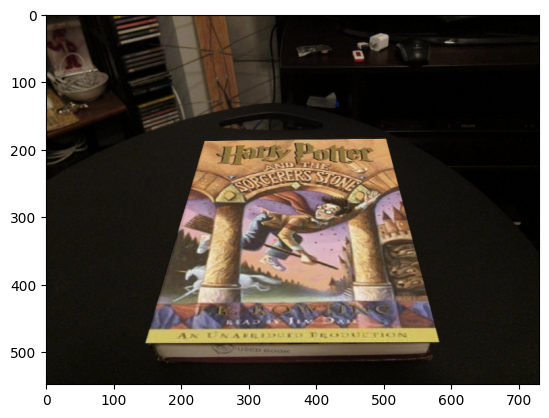

In [82]:
# defaults are:
# ratio = 0.7
# sigma = 0.15
# max_iters = 600
# inlier_tol = 1.0

# (no need to change this but can if you want to experiment)
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

warpImage(ratio, sigma, max_iters, inlier_tol)

### Q2.2.5 (10 points):

Conduct ablation study with various max_iters and inlier_tol values. Plot the result images and explain the effect of these two parameters respectively.

C:\Users\javie\AppData\Local\Temp\ipykernel_19760\3357110167.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0].item()+row1), int(center[1].item()+col1)] < img[int(center[0].item()+row2), int(center[1].item()+col2)] else 0
C:\Users\javie\AppData\Local\Temp\ipykernel_19760\3357110167.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0].item()+row1), int(center[1].item()+col1)] < img[int(center[0].item()+row2), int(center[1].item()+col2)] else 0
C:\Users\javie\AppData\Local\Temp\ipykernel_19760\3357110167.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar

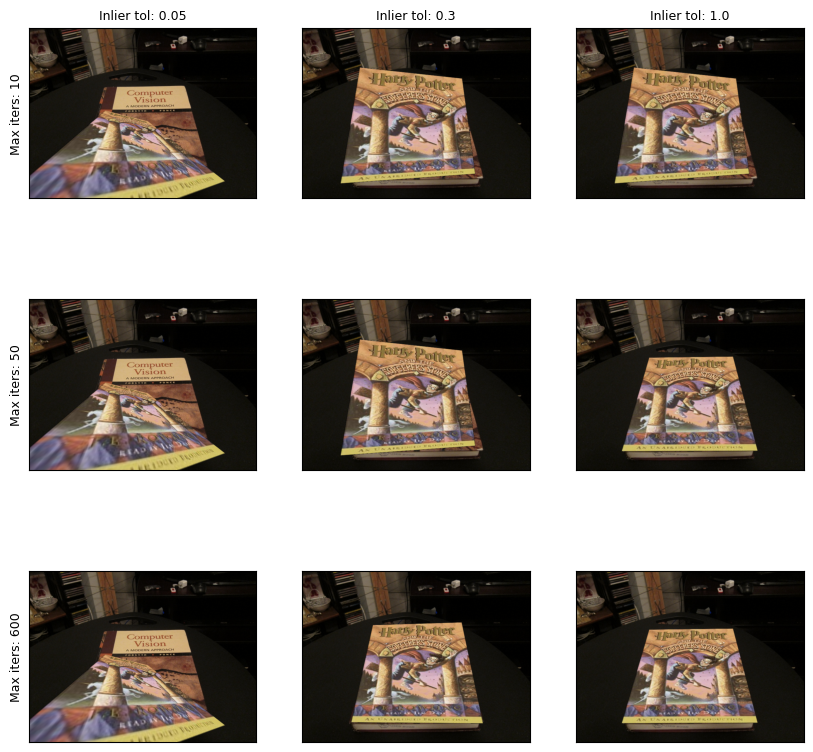

In [101]:
# ===== your code here! =====
# Experiment with different max_iters and inlier_tol values.
# Include the result images in the write-up.

ratio = 0.7
sigma = 0.15

# max_iters = 600
# inlier_tol = 1.0

k = 0
plt.figure(figsize=(10,10))
for max_iters in [10, 50, 600]:
    for inlier_tol in [0.05, 0.3, 1.0]:
        k += 1
        plt.subplot(3,3,k)
        warpImage(ratio, sigma, max_iters, inlier_tol, show=False)
        if (k-1) // 3 == 0: plt.title(f"Inlier tol: {inlier_tol}", fontsize=9)
        if k % 3 == 1: plt.ylabel(f"Max iters: {max_iters}", fontsize=9)
        plt.xticks([])
        plt.yticks([])
plt.show()

# ==== end of code ====

---

Explain the effect of max_iters and inlier_tol: 

From the results in the image, we can analyze the effects of **max_iters** (maximum RANSAC iterations) and **inlier_tol** (inlier tolerance) in the homography estimation process.

1. **Effect of Inlier Tolerance (inlier_tol)**:
   - When **inlier_tol is very small (0.05, first column)**, the model is overly strict, treating many good matches as outliers. This leads to poor homography estimation since we are rejecting too many correct correspondences.
   - With **moderate inlier_tol (0.3, second column)**, some incorrect matches are still affecting the transformation, but increasing the number of iterations helps refine the results.
   - When **inlier_tol is large enough (1.0, third column)**, the model is more forgiving and includes enough correct correspondences, leading to a better transformation even with fewer iterations.

2. **Effect of Maximum Iterations (max_iters)**:
   - With **low iterations (10, first row)**, the model does not have enough chances to filter out outliers, especially with a small inlier_tol.
   - Increasing to **50 iterations (second row)** improves results, particularly for moderate inlier_tol values.
   - With **high iterations (600, third row)**, the model has enough attempts to properly separate inliers from outliers, improving the estimation, especially when inlier_tol is reasonable.

### **Main Takeaways:**
- If **inlier_tol is too small**, even a high number of iterations cannot fully recover a good transformation.
- A **higher number of iterations** helps improve results, but only if inlier_tol is not too restrictive.
- With a **good inlier_tol (1.0), fewer iterations** (e.g., 50) are already enough to find the correct transformation.

This experiment highlights the importance of tuning **both** parameters together to achieve robust feature matching.

---

# Q3 Create a Simple Panorama

## Q3.1 Create a panorama (10 points):

#### Implement the function createPanorama

In [ ]:
def createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol):
    """
    Create a panorama augmented reality application by computing a homography
    and stitching together a left and right image.

    Input
    -----
    left_im: left image
    right_im: right image
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    panorama_im: Stitched together panorama

    """

    # ===== your code here! =====
    # TODO: match features between images
    # This can be done using matchPics, cpselect, or any other function.

    # 1) Match features
    matches, locs1, locs2 = matchPics(left_im, right_im, ratio, sigma)
    # Each row in 'matches' is [idx_left, idx_right].

    # 2) Reorder row,col -> x,y if needed
    #    If locs_left[i] is (row, col), swap to get (col, row) => (x, y).
    locs1  = locs1[:,  [1, 0]][matches[:, 0]].astype(float)
    locs2 = locs2[:, [1, 0]][matches[:, 1]].astype(float)

    # TODO: Get homography by RANSAC using computeH_ransac

    # 3) Compute homography from right -> left
    bestH, _ = computeH_ransac(locs1, locs2,
                               max_iters, inlier_tol)
    
    # 4) Create a wide canvas
    h_left, w_left   = left_im.shape[:2]
    h_right, w_right = right_im.shape[:2]

    pano_height = max(h_left, h_right)
    pano_width  = w_left + w_right

    panorama_im = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)

    # Place the left image at the left side
    panorama_im[0:h_left, 0:w_left] = left_im

    # TODO: Stich together the two images
    # Requires the use of cv2.warpPerspective
    # panorama_im = None
    
    # 5) Warp right_im into the left_im coordinate space
    #    The third arg is (width, height) => (pano_width, pano_height)
    warped_right = cv2.warpPerspective(right_im, bestH, (pano_width, pano_height))

    # 6) Overlay: where warped_right is non-black, copy to panorama
    mask = (warped_right.sum(axis=2) > 0)
    panorama_im[mask] = warped_right[mask]

    # 7) Crop out any remaining black region
    gray = np.sum(panorama_im, axis=2)  # sum of R,G,B => 0 if black
    nonzero_coords = np.argwhere(gray > 0)
    if len(nonzero_coords) > 0:
        min_row = np.min(nonzero_coords[:, 0])
        max_row = np.max(nonzero_coords[:, 0])
        min_col = np.min(nonzero_coords[:, 1])
        max_col = np.max(nonzero_coords[:, 1])
        panorama_im = panorama_im[min_row:max_row+1, min_col:max_col+1]

    # ==== end of code ====

    return panorama_im.astype(np.uint8)

#### Visualize Panorama

Make sure to use **your own images** and **include them as well as the result** in the report.

C:\Users\javie\AppData\Local\Temp\ipykernel_26848\3357110167.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0].item()+row1), int(center[1].item()+col1)] < img[int(center[0].item()+row2), int(center[1].item()+col2)] else 0


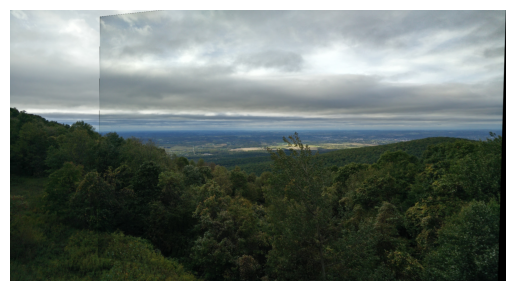

In [24]:
left_im_path = os.path.join(DATA_DIR, 'pano_left.jpg')
left_im = skimage.io.imread(left_im_path)
right_im_path = os.path.join(DATA_DIR, 'pano_right.jpg')
right_im = skimage.io.imread(right_im_path)

# Feel free to adjust as needed
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

panorama_im = createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol)

plt.imshow(panorama_im)
plt.axis('off')
plt.show()

In [25]:
left_im_path = os.path.join(DATA_DIR, 'left.jpeg')
left_im = skimage.io.imread(left_im_path)
right_im_path = os.path.join(DATA_DIR, 'right.jpeg')
right_im = skimage.io.imread(right_im_path)

# Feel free to adjust as needed
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

panorama_im = createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol)

C:\Users\javie\AppData\Local\Temp\ipykernel_26848\3357110167.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0].item()+row1), int(center[1].item()+col1)] < img[int(center[0].item()+row2), int(center[1].item()+col2)] else 0


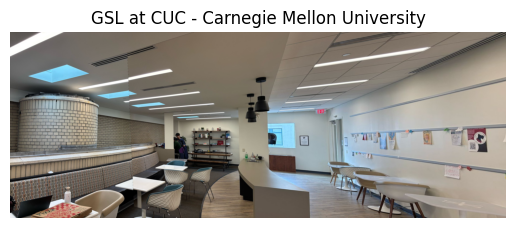

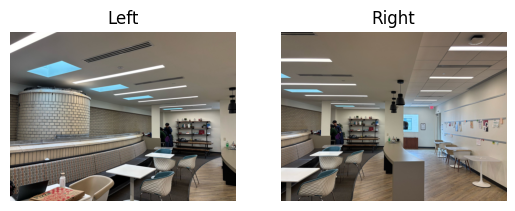

In [26]:
plt.title("GSL at CUC - Carnegie Mellon University")
plt.imshow(panorama_im)
plt.axis('off')
plt.show()

plt.subplot(1,2,1)
plt.title("Left")
plt.imshow(left_im)
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Right")
plt.imshow(right_im)
plt.axis('off')
plt.show()